In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os

from anki.storage import Collection
from anki.notes import Note

from fretboard import FretBoard
from fretboard_utils import draw

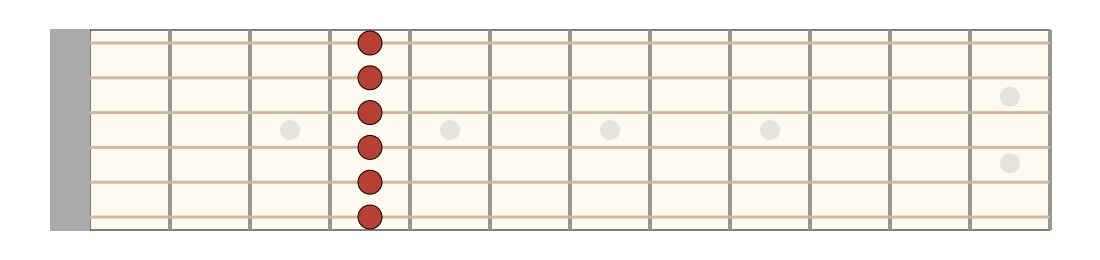

In [4]:
fretboard = FretBoard()
for string in range(1, 7):
    fretboard.add_note(string, 4)

draw(fretboard)

In [8]:
DECK_NAME = "Guitar"
ANKI_USER_NAME = "User 1"
COLLECTION_PATH = os.path.expanduser(f"~/Library/Application Support/Anki2/{ANKI_USER_NAME}/collection.anki2")
ANKI_MEDIA_PATH = os.path.expanduser(f"~/Library/Application Support/Anki2/{ANKI_USER_NAME}/collection.media")


# This has some interaction with the Anki app I haven't figured out yet. What I know is that it works when the Anki app
# is closed. Seems like only one source can open the collection at a time or something.
# TODO: Wrap this in a context manager that closes the collection when it's done.
# TODO: Make this work with the Anki app open, or make it impossible to run with the Anki app open.

# col = Collection(COLLECTION_PATH)
# model = col.models.by_name("Basic")
# deck_id = col.decks.id(DECK_NAME)
# col.close()

In [31]:
# TODO: This would probably be a bit cleaner as a class.
def make_anki_card_generator(col, model, deck_id, question_text_fn, img_fname_fn, question_fretboard_fn, answer_fn):
    def anki_card_generator(*args, **kwargs):
        question_text = question_text_fn(*args, **kwargs)
        img_fname = img_fname_fn(*args, **kwargs)
        img_fpath = os.path.join(ANKI_MEDIA_PATH, img_fname)
        question = question_text + f"\n\n<img src='{img_fname}'>"
        question_fretboard = question_fretboard_fn(*args, **kwargs)
        question_fretboard.export(to=img_fpath, format="png")
        answer = answer_fn(*args, **kwargs)

        note = Note(col, model)
        note.fields = [question, answer]
        col.add_note(note, deck_id=deck_id)

    return anki_card_generator

# `inputs` really should be a list of tuples but I'm not gonna bother for this first example.
def generate_anki_cards(question_text_fn, img_fname_fn, question_fretboard_fn, answer_fn, inputs):
    col = Collection(COLLECTION_PATH)
    model = col.models.by_name("Basic")
    deck_id = col.decks.id(DECK_NAME)

    anki_card_generator = make_anki_card_generator(
        col, model, deck_id, question_text_fn, img_fname_fn, question_fretboard_fn, answer_fn)

    for input in inputs:
        anki_card_generator(input)

    col.close()

In [28]:
label_notes_ascending = lambda _: "Label these notes in ascending order."
barre_img_fname = lambda fret: f"barre_{fret}.png"
def barre_question_fretboard(fret):
    fretboard = FretBoard()
    for string in range(1, 7):
        fretboard.add_note(string, fret)
    return fretboard
def barre_answer(fret, descending=False):
    chromatic = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    lowest = fret + 4
    notes = [lowest, lowest + 5, lowest + 10, lowest + 15, lowest + 19, lowest + 24]
    if descending:
        notes = notes[::-1]
    return ", ".join([chromatic[n % 12] for n in notes])

In [33]:
generate_anki_cards(
    label_notes_ascending, barre_img_fname, barre_question_fretboard, barre_answer, range(13))